# Reading and training tom and jerry dataset from kaggle

## Imports

In [1]:
import torch
from torch import nn

import torchvision

from pathlib import Path

from matplotlib import pyplot as plt

In [2]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device ='mps'

print(f'device: {device}')

device: cuda


## In pc

In [ ]:
data_path = Path(
    '/home/ramin/ramin_programs/files/datasets/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry')

## In colab

In [3]:
from google.colab import userdata

In [4]:
kaggle_target_path = Path('/root/.kaggle/kaggle.json')

kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

with open(kaggle_target_path,'w') as f:
  f.write(userdata.get('Kaggle'))

In [5]:
! kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

100% 433M/435M [00:22<00:00, 22.9MB/s]
100% 435M/435M [00:22<00:00, 20.1MB/s]


In [6]:
! unzip -q tom-and-jerry-image-classification

In [7]:
! rm -r tom-and-jerry-image-classification.zip

In [8]:
data_path = Path('tom_and_jerry/tom_and_jerry')

## load data

In [9]:
tr = torchvision.transforms.Compose(
    [torchvision.transforms.Resize([90,160]),torchvision.transforms.ToTensor(),]
)

image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)

In [10]:
data_loader = torch.utils.data.DataLoader(image_folder,
                         batch_size=32,
                         shuffle=True
                         )

tensor(3)


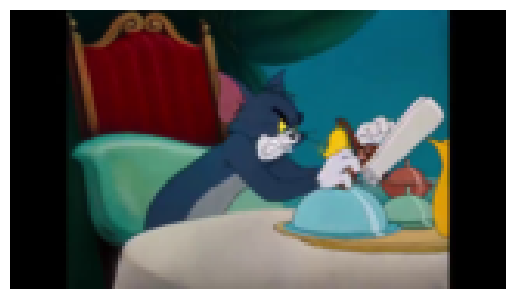

In [11]:
for tensor_image, label in data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

In [12]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 71.1MB/s]


In [13]:
model.classifier[1] = nn.Linear(1280,4)

In [14]:
model = model.to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
def train(model, data_loader, loss_fn, optimizer):
    data_size = len(data_loader.dataset)
    model.train()
    for i, (images, labels) in enumerate(data_loader):

        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images)
        loss = loss_fn(y_pred, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100 == 0:
            print(f'{loss.item():>7f} {(i+1)*len(images)}/{data_size}')

In [17]:
def test(model, data_loader, loss_fn):
    data_size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)
            test_loss += loss_fn(y_pred, labels).item()
            correct += (y_pred.argmax(1) ==
                        labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= data_size

    print(f'loss: {test_loss}, accuracy: {correct}')

In [18]:
for epoch in range(5):
    train(model, data_loader, loss_fn, optimizer)
    test(model, data_loader, loss_fn)
    print(f'epoch {epoch} is over')

1.413446 32/5478
0.509141 3232/5478
loss: 0.3375963416643614, accuracy: 0.8793355239138372
epoch 0 is over
0.728981 32/5478
0.138605 3232/5478
loss: 0.25055661520292594, accuracy: 0.9101861993428259
epoch 1 is over
0.406455 32/5478
0.219538 3232/5478
loss: 0.1337786265107435, accuracy: 0.9565534866739686
epoch 2 is over
0.321957 32/5478
0.177763 3232/5478
loss: 0.3279780856831822, accuracy: 0.8716684921504199
epoch 3 is over
0.174405 32/5478
0.272870 3232/5478
loss: 0.10626460741772208, accuracy: 0.9633077765607886
epoch 4 is over
